# Analyse Spatial Patterns in Classifications

In [15]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [114]:
def plot_rose(ax, indicators, lsoa_code, color):
    this_lsoa = indicators[indicators['LSOA11CD'] == lsoa_code]
    this_lsoa.reset_index(inplace=True, drop=True)
    del this_lsoa['LSOA11CD']
    del this_lsoa['LA_NAME']
    del this_lsoa['gentrification_prediction_code']
    this_lsoa_T = this_lsoa.T
    this_lsoa_T.reset_index(inplace=True)
    this_lsoa_T = this_lsoa_T.rename(columns={0: 'scores'})
    # E01014485_T['max_vals'] = max_vals[0].values
    df = this_lsoa_T.copy()
    # df['pct'] = df['scores'] / df['max_vals']
    df = df.set_index('index')
    
    # Replace NaN values with 0 in the plot data (but keep NaNs in the DataFrame)
    df['scores_for_plot'] = df['scores'].fillna(0)
    
    # Recalculate N and angles after replacing NaNs
    N = df.shape[0]
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    
    # Assign new angles
    df['radar_angles'] = theta
    
    # Plot
    ax.bar(df['radar_angles'], df['scores_for_plot'], width=2 * np.pi / N, linewidth=2, edgecolor='k', alpha=0.6, color=color)
    
    # Adjust labels (keeping original categories with NaNs)
    ax.set_xticks(theta)
    ax.set_xticklabels(df.index)
    ax.set_yticklabels([])

### Get gentrification scores

In [5]:
city='melbourne'
central_suburbs = gpd.read_file(f"../../../data/SpatialData/MelbourneSuburbs.shp")

In [8]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
gentrification_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_combined_listings_filtered_01.csv')

In [11]:
gentrification_df['geometry'] = gentrification_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gentrification_gdf = gpd.GeoDataFrame(gentrification_df, geometry='geometry', crs="EPSG:4326")

In [12]:
mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
gentrification_gdf['gentrification_prediction_code'] = gentrification_gdf['gentrification_prediction'].map(mapping)

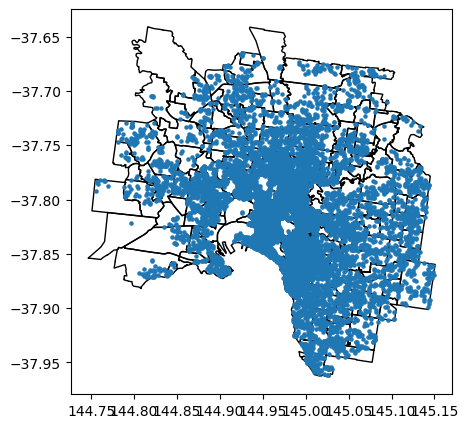

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
central_suburbs.plot(ax=ax, edgecolor = 'black', facecolor='none'), 
gentrification_gdf.plot(ax=ax,  markersize=5);

### Get summary score for each suburb

In [17]:
suburb_scores_gentrification = gentrification_gdf.groupby("SAL_NAME21")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0])
suburb_scores_gentrification_df = pd.DataFrame(suburb_scores_gentrification)
suburb_scores_gentrification_df.reset_index(inplace=True)

suburb_counts_gentrification = gentrification_gdf.groupby("SAL_NAME21")["gentrification_prediction_code"].count()
suburb_counts_gentrification_df = pd.DataFrame({'count': suburb_counts_gentrification})
suburb_counts_gentrification_df.reset_index(inplace=True)

suburb_scores_gentrification_df = suburb_scores_gentrification_df.merge(suburb_counts_gentrification_df, on='SAL_NAME21', how='outer')

In [18]:
central_suburbs = central_suburbs.merge(suburb_scores_gentrification_df, on='SAL_NAME21', how='left')

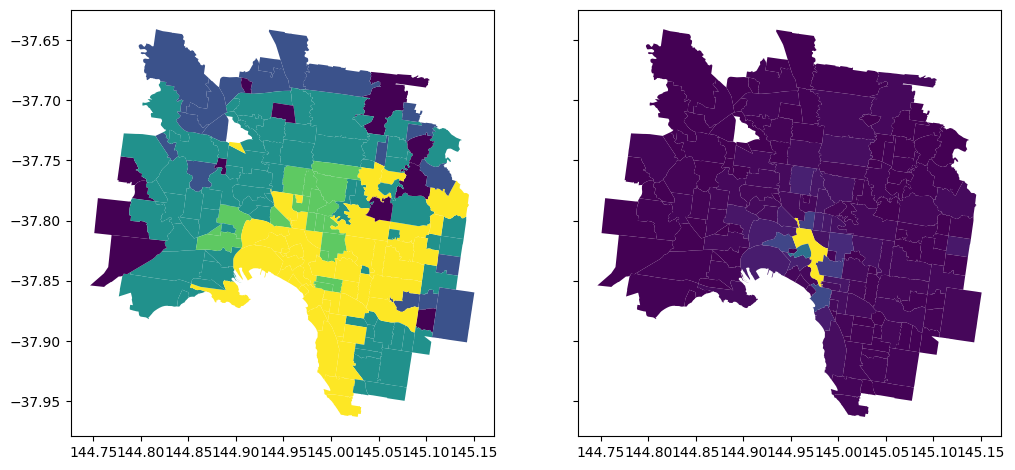

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(12,7), sharey=True)
central_suburbs.plot('gentrification_prediction_code', ax=axs[0])
central_suburbs.plot('count', ax=axs[1]);

### Compare to the index

In [32]:
index = pd.read_csv(f"../../../data/GentrificationIndex/MelbourneIndex/Edited.csv")
scores_and_index = suburb_scores_gentrification_df.merge(index, on='SAL_NAME21', how='left')

### Drop the NA scores for the LLM cats

In [34]:
scores_and_index = scores_and_index[scores_and_index['gentrification_prediction_code']!=0]

In [35]:
# Cross-tabulation
crosstab = pd.crosstab(scores_and_index['gentrification_prediction_code'], scores_and_index['classification_new'])
crosstab


classification_new              0.0  1.0  2.0  3.0
gentrification_prediction_code                    
1.0                               5    7    5    2
2.0                               7    8   37   17
3.0                               0    0    3   15
4.0                               3    0    4   38

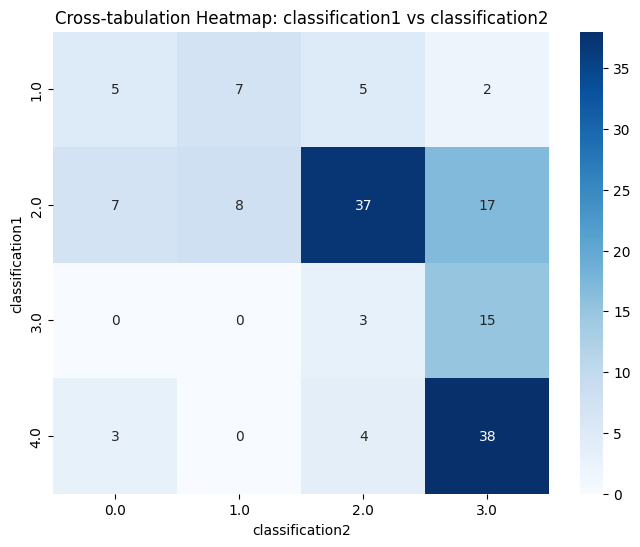

In [38]:
import seaborn as sns

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Cross-tabulation Heatmap: classification1 vs classification2')
plt.xlabel('classification2')
plt.ylabel('classification1')
plt.show()


In [42]:
import plotly.graph_objects as go

# Get the cross-tab as a flat list
ct = crosstab

# Prepare labels
labels = [f'cls1_{i}' for i in ct.index] + [f'cls2_{j}' for j in ct.columns]

# Map indices for Sankey
source = []
target = []
value = []

for i, row in enumerate(ct.index):
    for j, col in enumerate(ct.columns):
        source.append(i)                # classification1 index
        target.append(len(ct.index)+j)  # classification2 index offset
        value.append(ct.loc[row, col])  # count

# Build Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=labels,
        color='blue'
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    ))])

fig.update_layout(title_text="Sankey Diagram: classification1 to classification2", font_size=12)
fig.show()
